### Introduction
Monkeypox is a viral disease affecting both humans and animals. It is casued by the Monkeypox Virus which is zoonotic and is of the family Orthopoxviruses
The ongoing outbreak was confrimed in May of 2022 with a cluster of cases in United Kingdom on a patient with travel history to Nigeria where the virus is endemic.
The disease has since spread to ther countries in the world predominantly Europe.
It has since been declared an evolving concern as opposed to a public health emergency of worldwide/international concern.

To counter its rapid spread, early diagnosis and identification is key. However,the confirmatory PCR and other biochemical tests are not easily available,are very costly and not available in sufficient quantities.

To this end there was need to develop a computer-aided tool that will help identify and act as a means of triaging the suspected patients before they are subjected to confirmatory tests. 
There being limited data on the same, we leveraged the https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset that was created by scrapping the web for images reported and publicly available case reports.

### Workflow Representation.

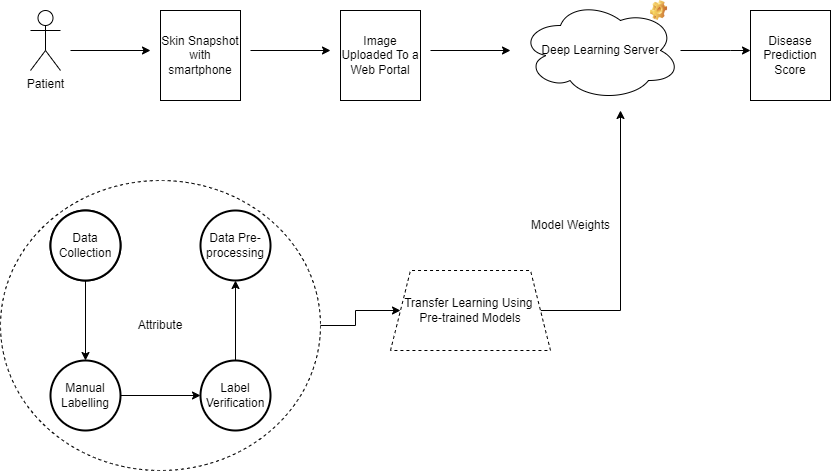

### Dataset and Dataset Description
The dataset used here was created withe the primary focus of telling apart monkepox leisons from other cases that might clinically resemble monkeypox i.e the rash and pustules in measles and chicken pox caused by Measles virus and Varicella Zooster Virus respectively resemble monkeypox in ther initial/earlier stages.
For purposes of this task the dataset was grouped into two: Monkeypox cases and non-monkeypox cases also called 'others' so that this task is performed as a binary classification task.

The dataset was arranged in 3 distinct folders
1. This folder had the original images. 228 in number divided as follows: 102 of the Monkeypox class and 126 of the Other/Non-monkeypox class
2. This folder has augmented images to aid in this task. A number of augmentation techniques were employed.
3. To reduce bias a fthis folder was created to do a cross-validation; with the original images being split into training test and validation sets in the ratios 70:20:10 all this while maintaining patient independence.

The training and validation sets were the augmented images while the test images were the original ones

A CSV file containing the image metadata was also included.

### Classification Task

In [1]:
#importing required libraries
import os
import numpy as np

np.random.seed(42)

import pandas as pd

import random
random.seed(42)

import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
from PIL import Image
from scipy import misc

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
import keras.backend as K 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Add, Multiply, Subtract, AveragePooling2D
from keras.layers.core import Dense, Lambda
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, Flatten

In [3]:
from tensorflow.keras.utils import plot_model
from keras.optimizers import *
from keras.callbacks import *
from keras.activations import *

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

### Loading Data

In [5]:
#Data Importation
train_loc='C:/Users/HP/Desktop/Monkeypox Classification/archive (4)/Fold1/Fold1/Fold1/Train'
validation_loc='C:/Users/HP/Desktop/Monkeypox Classification/archive (4)/Fold1/Fold1/Fold1/Val'
test_loc='C:/Users/HP/Desktop/Monkeypox Classification/archive (4)/Fold1/Fold1/Fold1/Test'

In [ ]:
BATCH_SIZE=16

In [ ]:
#TrainingData
trdata=ImageDataGenerator()
train_data=trdata.flow_from_directory(directory=train_loc,target_size=(224,224),batch_size=BATCH_SIZE,shuffle=True,seed=42)

#ValidationData
vdata=ImageDataGenerator()
val_data=vdata.flow_from_directory(directory=validation_loc,target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,seed=42)

#TestData
tsdata=ImageDataGenerator()
test_data=tsdata.flow_from_directory(directory=test_loc,target_size=(224,224),batch_size=BATCH_SIZE,shuffle=False,seed=42)

In [ ]:
train_data.class_indices

### Model Creation

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
#defining a function to create a model.
def create_model(input_shape, n_classes, optimizer, fine_tune):
   
    """
    Compiles a model that is combined with MobileNetV2 pretrained layers
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
    If set to 0, all pretrained layers will be frozen during training
    """
    #pre-trained convolution layers are loaded with the Image weights
    #the models fully connected layers are excluded

    conv_base=InceptionV3(include_top=False,
    weights='imagenet',
    input_shape=input_shape)
#we then define how many layers we freeze during training
#convolutional base layers can be changed from trainable to no-trainable based on the size of the parameter we use to fine-tune

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    top_model=conv_base.output
    top_model=Flatten(name='flatten')(top_model)
    top_model=Dense(4096,activation='relu')(top_model)
    top_model=Dropout(0.3)(top_model)
    top_model=Dense(1072,activation='relu')(top_model)
    top_model=Dropout(0.2)(top_model)
    top_model=Dense(256,activation='relu')(top_model)
    top_model=Dropout(0.15)(top_model)
    output_layer=Dense(n_classes,activation='softmax')(top_model)

    #Grouping the convolutional base and fully connected layers

    model=Model(inputs=conv_base.input,outputs=output_layer)

    #compiling the model for training
    model.compile (optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
input_shape=(224,224,3)
opt=tf.keras.optimizers.Adam(learning_rate=0.00001)
n_classes=2
ft=8
model=create_model(input_shape,n_classes,opt,fine_tune=ft)


In [ ]:
len(model.layers)

In [ ]:
plot_model(model,to_file="model.png",show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96,)

In [ ]:
pip install livelossplot


In [ ]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=val_data.n//test_data.batch_size
n_epochs=100

from collections import Counter
counter=Counter(train_data.classes)
max_val=float(max(counter.values()))
class_weights={class_id:max_val/num_images for class_id,num_images in counter.items()}
class_weights

from livelossplot import PlotLossesKeras

checkpoint=ModelCheckpoint("/working/InceptionV3.h5",monitor='val_accuracy',verbose=1,save_best_only=True, save_weights_only=False,mode='auto')

early_stop=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=20,verbose=1,mode='auto',restore_best_weights=True)

In [ ]:
history=model.fit(train_data,
                 epochs=100,
                 steps_per_epoch=STEP_SIZE_TRAIN,
                 class_weight=class_weights,
                 validation_data=val_data,
                 validation_steps=STEP_SIZE_VALID,
                 callbacks=[checkpoint,early_stop,PlotLossesKeras()]
                 
                 )